In [1]:
# <-- Import libraries, custom functions, and load configuration & datasets <-- #

import yaml
import datetime as dt
import re
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import statsmodels.api as sm
import seaborn as sns

from statsmodels.multivariate.manova import MANOVA
from scipy import stats
from scipy.stats import pearsonr, boxcox, chi2_contingency
from scipy.stats.contingency import association

# <-- Imports custom preprocessing functions from 'functions.py' <-- #

# from functions import ()

# <-- Loads YAML configuration to dynamically reference CSV output files. <-- #

config = None  # <-- Initialize config
try:
    with open("../config.yaml", "r") as file:
        config = yaml.safe_load(file)
except:
    print("Yaml configuration file not found!")


df_demo = pd.read_csv(config['input_data']['file1'])
df_exp_clients = pd.read_csv(config['input_data']['file2'])
df_web_data_pt_1 = pd.read_csv(config['input_data']['file3'])
df_web_data_pt_2 = pd.read_csv(config['input_data']['file3'])

In [2]:
display(df_demo)
print(df_demo.dtypes)

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0
...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0


client_id             int64
clnt_tenure_yr      float64
clnt_tenure_mnth    float64
clnt_age            float64
gendr                object
num_accts           float64
bal                 float64
calls_6_mnth        float64
logons_6_mnth       float64
dtype: object


In [3]:
display(df_exp_clients)
print(df_exp_clients.dtypes)

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control
...,...,...
70604,2443347,NaN
70605,8788427,NaN
70606,266828,NaN
70607,1266421,NaN


client_id     int64
Variation    object
dtype: object


In [4]:
display(pd.DataFrame({
    "non_nulls": df_exp_clients.count(),
    "nulls": df_exp_clients.isnull().sum(),
    "total": len(df_exp_clients)
}))

,non_nulls,nulls,total
client_id,70609,0,70609
Variation,50500,20109,70609


In [5]:
df_exp_clients.dropna(inplace=True)

In [6]:
# Drop rows of clients not inlcuded in the experiment
df_exp_clients.shape, df_exp_clients.isnull().sum()

((50500, 2),
 client_id    0
 Variation    0
 dtype: int64)

In [7]:
# client_id == 4666211 [only client with not age]
df_exp_clients[df_exp_clients['client_id'] == 4666211]

,client_id,Variation
38552,4666211,Control


In [8]:
display(df_web_data_pt_1.sort_values(by=['date_time'],ascending=True))
print(df_web_data_pt_1.dtypes)

,client_id,visitor_id,visit_id,process_step,date_time
286566,9088444,242404224_96732670250,423038079_46067236368_400417,step_3,2017-03-15 00:03:03
35293,7179755,167765295_97487764427,264484508_5982901710_928530,start,2017-03-15 00:19:28
35292,7179755,167765295_97487764427,264484508_5982901710_928530,step_1,2017-03-15 00:20:50
35291,7179755,167765295_97487764427,264484508_5982901710_928530,step_2,2017-03-15 00:22:52
35290,7179755,167765295_97487764427,264484508_5982901710_928530,step_3,2017-03-15 00:23:47
...,...,...,...,...,...
145626,5402972,481155336_6881867780,989795424_84700610095_958376,step_3,2017-04-30 23:57:56
80224,8007865,502318665_28702751895,104145193_36067138148_118971,start,2017-04-30 23:57:59
80223,8007865,502318665_28702751895,104145193_36067138148_118971,start,2017-04-30 23:58:00
267801,3564156,804345132_94518026695,105759035_3338544759_200972,start,2017-04-30 23:59:16


client_id        int64
visitor_id      object
visit_id        object
process_step    object
date_time       object
dtype: object


In [9]:
display(df_web_data_pt_2.sort_values(by=['date_time'],ascending=True))
print(df_web_data_pt_2.dtypes)

,client_id,visitor_id,visit_id,process_step,date_time
286566,9088444,242404224_96732670250,423038079_46067236368_400417,step_3,2017-03-15 00:03:03
35293,7179755,167765295_97487764427,264484508_5982901710_928530,start,2017-03-15 00:19:28
35292,7179755,167765295_97487764427,264484508_5982901710_928530,step_1,2017-03-15 00:20:50
35291,7179755,167765295_97487764427,264484508_5982901710_928530,step_2,2017-03-15 00:22:52
35290,7179755,167765295_97487764427,264484508_5982901710_928530,step_3,2017-03-15 00:23:47
...,...,...,...,...,...
145626,5402972,481155336_6881867780,989795424_84700610095_958376,step_3,2017-04-30 23:57:56
80224,8007865,502318665_28702751895,104145193_36067138148_118971,start,2017-04-30 23:57:59
80223,8007865,502318665_28702751895,104145193_36067138148_118971,start,2017-04-30 23:58:00
267801,3564156,804345132_94518026695,105759035_3338544759_200972,start,2017-04-30 23:59:16


client_id        int64
visitor_id      object
visit_id        object
process_step    object
date_time       object
dtype: object


In [10]:
df_web_data_pt_1[df_web_data_pt_1['client_id'] == 1702].sort_values(by='date_time')

,client_id,visitor_id,visit_id,process_step,date_time
189056,1702,470573753_93844895765,243444359_78696078676_118990,confirm,2017-04-01 11:44:04


In [11]:
df_web_data_pt_2[df_web_data_pt_2['client_id'] == 1702].sort_values(by='date_time')

,client_id,visitor_id,visit_id,process_step,date_time
189056,1702,470573753_93844895765,243444359_78696078676_118990,confirm,2017-04-01 11:44:04


In [12]:
# Concatenate the two web data parts vertically and drop duplicates
df_web_data = pd.concat([df_web_data_pt_1, df_web_data_pt_2], ignore_index=True).drop_duplicates().reset_index(drop=True).sort_values(by=['date_time'],ascending=True)
print(f"Combined shape: {df_web_data.shape}")
print(f"Original shapes: {df_web_data_pt_1.shape} + {df_web_data_pt_2.shape}")
df_web_data.sort_values(by=['date_time'],ascending=True)

Combined shape: (341046, 5)
Original shapes: (343141, 5) + (343141, 5)


,client_id,visitor_id,visit_id,process_step,date_time
284865,9088444,242404224_96732670250,423038079_46067236368_400417,step_3,2017-03-15 00:03:03
35092,7179755,167765295_97487764427,264484508_5982901710_928530,start,2017-03-15 00:19:28
35091,7179755,167765295_97487764427,264484508_5982901710_928530,step_1,2017-03-15 00:20:50
35090,7179755,167765295_97487764427,264484508_5982901710_928530,step_2,2017-03-15 00:22:52
35089,7179755,167765295_97487764427,264484508_5982901710_928530,step_3,2017-03-15 00:23:47
...,...,...,...,...,...
286660,1104891,710002770_61911521918,597284396_96145314289_460044,step_1,2017-04-30 23:57:32
144767,5402972,481155336_6881867780,989795424_84700610095_958376,step_3,2017-04-30 23:57:56
79749,8007865,502318665_28702751895,104145193_36067138148_118971,start,2017-04-30 23:57:59
79748,8007865,502318665_28702751895,104145193_36067138148_118971,start,2017-04-30 23:58:00


In [13]:
# client_id == 4666211 [only client with not age]
df_web_data[df_web_data['client_id'] == 4666211].sort_values(by='date_time')

,client_id,visitor_id,visit_id,process_step,date_time
186266,4666211,856388890_23198552132,193475184_47241294073_678330,start,2017-03-31 07:24:38
186265,4666211,856388890_23198552132,193475184_47241294073_678330,step_1,2017-03-31 07:25:15
186264,4666211,856388890_23198552132,193475184_47241294073_678330,step_2,2017-03-31 07:26:05
186263,4666211,856388890_23198552132,193475184_47241294073_678330,step_3,2017-03-31 07:26:36
186262,4666211,856388890_23198552132,193475184_47241294073_678330,start,2017-03-31 07:32:08
186261,4666211,856388890_23198552132,193475184_47241294073_678330,start,2017-03-31 07:32:21
186224,4666211,856388890_23198552132,740801132_41889378563_243921,start,2017-04-09 08:13:46
186223,4666211,856388890_23198552132,740801132_41889378563_243921,start,2017-04-09 08:14:13
186222,4666211,856388890_23198552132,740801132_41889378563_243921,step_1,2017-04-09 08:17:04
186221,4666211,856388890_23198552132,740801132_41889378563_243921,step_2,2017-04-09 08:17:09


In [14]:
df_web_data.nunique()

client_id        58391
visitor_id       62936
visit_id         75256
process_step         5
date_time       282666
dtype: int64

In [15]:
df_web_data['process_step'].unique()

array(['step_3', 'start', 'step_1', 'step_2', 'confirm'], dtype=object)

In [16]:
df_demo.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age', 'gendr',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth'],
      dtype='object')

In [17]:
df_exp_clients.columns

Index(['client_id', 'Variation'], dtype='object')

In [18]:
# Merge df_demo with df_exp_clients on 'client_id' to add 'Variation' column
df_demo = df_demo.merge(df_exp_clients[['client_id', 'Variation']], on='client_id', how='left')

# Show the result to verify
df_demo

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0,Test
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0,Control
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0,Test
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0,Test
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0,Control
...,...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,NaN
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,NaN
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,NaN
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,NaN


In [19]:
display(pd.DataFrame({
    "non_nulls": df_demo.count(),
    "nulls": df_demo.isnull().sum(),
    "total": len(df_demo)
}))

,non_nulls,nulls,total
client_id,70609,0,70609
clnt_tenure_yr,70595,14,70609
clnt_tenure_mnth,70595,14,70609
clnt_age,70594,15,70609
gendr,70595,14,70609
num_accts,70595,14,70609
bal,70595,14,70609
calls_6_mnth,70595,14,70609
logons_6_mnth,70595,14,70609
Variation,50500,20109,70609


In [20]:
# Check the unique values,
df_demo['Variation'].value_counts(dropna=False)

Variation
Test       26968
Control    23532
NaN        20109
Name: count, dtype: int64

In [21]:
# Counting and sorting the unique values for each numerical column in descending order
df_demo.select_dtypes("number").nunique().sort_values(ascending=False)

client_id           70609
bal                 70328
clnt_tenure_mnth      482
clnt_age              165
clnt_tenure_yr         54
logons_6_mnth           9
num_accts               8
calls_6_mnth            8
dtype: int64

In [22]:
display(pd.DataFrame({
    "non_nulls": df_demo.count(),
    "nulls": df_demo.isnull().sum(),
    "total": len(df_demo)
}))

,non_nulls,nulls,total
client_id,70609,0,70609
clnt_tenure_yr,70595,14,70609
clnt_tenure_mnth,70595,14,70609
clnt_age,70594,15,70609
gendr,70595,14,70609
num_accts,70595,14,70609
bal,70595,14,70609
calls_6_mnth,70595,14,70609
logons_6_mnth,70595,14,70609
Variation,50500,20109,70609


In [23]:
df_demo.shape, df_demo.isnull().sum()

((70609, 10),
 client_id               0
 clnt_tenure_yr         14
 clnt_tenure_mnth       14
 clnt_age               15
 gendr                  14
 num_accts              14
 bal                    14
 calls_6_mnth           14
 logons_6_mnth          14
 Variation           20109
 dtype: int64)

In [24]:
df_demo.drop_duplicates(subset='client_id').count()

client_id           70609
clnt_tenure_yr      70595
clnt_tenure_mnth    70595
clnt_age            70594
gendr               70595
num_accts           70595
bal                 70595
calls_6_mnth        70595
logons_6_mnth       70595
Variation           50500
dtype: int64

In [25]:
display(pd.DataFrame({
    "non_nulls": df_exp_clients.count(),
    "nulls": df_exp_clients.isnull().sum(),
    "total": len(df_exp_clients)
}))

,non_nulls,nulls,total
client_id,50500,0,50500
Variation,50500,0,50500


In [26]:
# Calculate the mean, median, mode, variance, and standard deviation of 'clnt_age'.
data={"mean": [df_demo['clnt_age'].mean()], "median": [df_demo['clnt_age'].median()],
 "mode": [df_demo['clnt_age'].mode()[0]], "sd": [df_demo['clnt_age'].std()]}
display(pd.DataFrame(data))

,mean,median,mode,sd
0,46.44224,47.0,58.5,15.591273


In [27]:
# Discretizing 'clnt_age' into quartiles
df_demo['clnt_age_quantile'] = pd.qcut(df_demo['clnt_age'], q=4, labels=['A1', 'A2', 'A3', 'A4'])
df_demo.clnt_age_quantile.value_counts()

clnt_age_quantile
A3    18041
A1    17853
A2    17674
A4    17026
Name: count, dtype: int64

In [28]:
# Show rows that have at least one missing value
df_demo[df_demo.isnull().any(axis=1)]

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation,clnt_age_quantile
4164,7402828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Control,NaN
8316,355337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Control,NaN
8677,8412164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN
9583,4666211,8.0,106.0,NaN,F,2.0,42550.55,4.0,7.0,Control,NaN
13444,2222915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test,NaN
...,...,...,...,...,...,...,...,...,...,...,...
70604,7993686,4.0,56.0,38.5,U,3.0,1411062.68,5.0,5.0,NaN,A2
70605,8981690,12.0,148.0,31.0,M,2.0,101867.07,6.0,6.0,NaN,A1
70606,333913,16.0,198.0,61.5,F,2.0,40745.00,3.0,3.0,NaN,A4
70607,1573142,21.0,255.0,68.0,M,3.0,475114.69,4.0,4.0,NaN,A4


In [29]:
df_demo[['clnt_tenure_yr','clnt_tenure_mnth','clnt_age']].describe()

,clnt_tenure_yr,clnt_tenure_mnth,clnt_age
count,70595.000000,70595.000000,70594.000000
mean,12.052950,150.659367,46.442240
std,6.871819,82.089854,15.591273
min,2.000000,33.000000,13.500000
25%,6.000000,82.000000,32.500000
50%,11.000000,136.000000,47.000000
75%,16.000000,192.000000,59.000000
max,62.000000,749.000000,96.000000


In [30]:
df_demo.groupby("clnt_age_quantile")['clnt_age'].agg(['count','mean','std','min','max','median','var'])

C:\Users\pablo\AppData\Local\Temp\ipykernel_3568\1410888566.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_demo.groupby("clnt_age_quantile")['clnt_age'].agg(['count','mean','std','min','max','median','var'])


,count,mean,std,min,max,median,var
clnt_age_quantile,,,,,,,
A1,17853,26.464992,4.046262,13.5,32.5,27.0,16.372234
A2,17674,39.978301,4.273162,33.0,47.0,40.0,18.259912
A3,18041,53.421401,3.386708,47.5,59.0,53.5,11.469792
A4,17026,66.704569,5.966074,59.5,96.0,65.5,35.594037


In [31]:
desc = df_demo['clnt_age'].describe()
# desc['std'], desc['min'], desc['max'], desc['25%'], desc['75%']
variance = round(df_demo['clnt_age'].var(), 2)
#std_dev = round(df_demo['clnt_age'].std(), 2)
age_range = (round(desc['min'],2), round(desc['max'],2))
iqr = desc['75%'] - desc['25%']

print(f'Age Variance: {variance}')
#print(f"Age Std Deviation: {std_dev}")
print(f'Age Range: {age_range}')
print(f"Age Interquartile Range: {iqr}")

Age Variance: 243.09
Age Range: (np.float64(13.5), np.float64(96.0))
Age Interquartile Range: 26.5


In [32]:
desc = df_demo['bal'].describe()
# desc['std'], desc['min'], desc['max'], desc['25%'], desc['75%']
variance = round(df_demo['bal'].var(), 2)
#std_dev = round(df_demo['bal'].std(), 2)
bal_range = (round(desc['min'],2), round(desc['max'],2))
iqr = desc['75%'] - desc['25%']

print(f'Balance Variance: {variance}')
print(f"Balance Std Deviation: {round(desc['std'],2)}")
print(f'Balance Range: {bal_range}')
print(f'Balance Average:{round(desc['mean'],2)}')
print(f"Balance Interquartile Range: {iqr}")

Balance Variance: 90907500113.94
Balance Std Deviation: 301508.71
Balance Range: (np.float64(13789.42), np.float64(16320040.15))
Balance Average:147445.24
Balance Interquartile Range: 100198.07


In [33]:
skewness_age = round(df_demo['clnt_age'].skew())
kurtosis_age = round(df_demo['clnt_age'].kurtosis())

skewness_age, kurtosis_age

(0, -1)

In [34]:
skewness_age = round(df_demo['bal'].skew())
kurtosis_age = round(df_demo['bal'].kurtosis())

skewness_age, kurtosis_age

(11, 278)

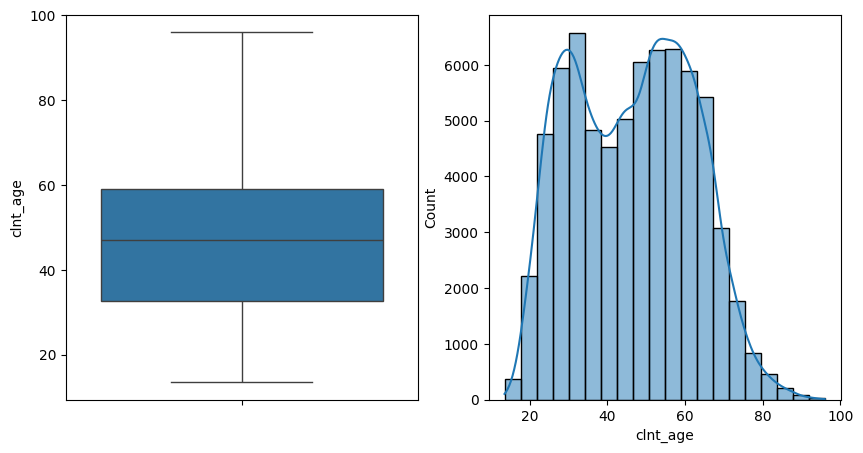

In [35]:
# Age distribution
fig, axes = plt.subplots(1,2,figsize=(10,5))
sns.boxplot(data=df_demo, y='clnt_age',ax=axes[0])
sns.histplot(df_demo['clnt_age'], kde=True, bins=20, ax=axes[1]);
plt.show()

In [36]:
df_demo['gendr'].unique()

array(['U', 'M', 'F', nan, 'X'], dtype=object)

In [37]:
df_demo['gendr'].value_counts(dropna=False)

gendr
U      24122
M      23724
F      22746
NaN       14
X          3
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='gendr_clean'>

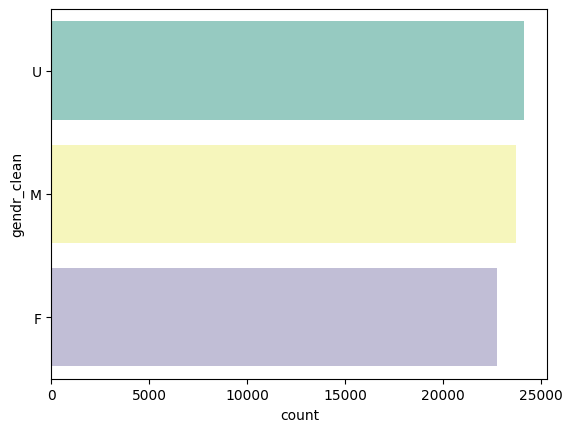

In [38]:
# Gender distribution
df_demo['gendr_clean'] = df_demo['gendr'].apply(lambda x: x if x in ['M', 'F'] else 'U')
sns.countplot(data=df_demo, y='gendr_clean', palette="Set3", hue='gendr_clean', legend=False)

In [39]:
def drop_irrelevant_columns(df: pd.DataFrame, columns) -> pd.DataFrame:
    df_drop_cols = df.drop(columns=columns, axis=1, errors="ignore")
    return df_drop_cols

cols = ['gendr_clean','gendr']
df_demo = drop_irrelevant_columns(df_demo,cols)

In [40]:
df_demo.columns

Index(['client_id', 'clnt_tenure_yr', 'clnt_tenure_mnth', 'clnt_age',
       'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth', 'Variation',
       'clnt_age_quantile'],
      dtype='object')

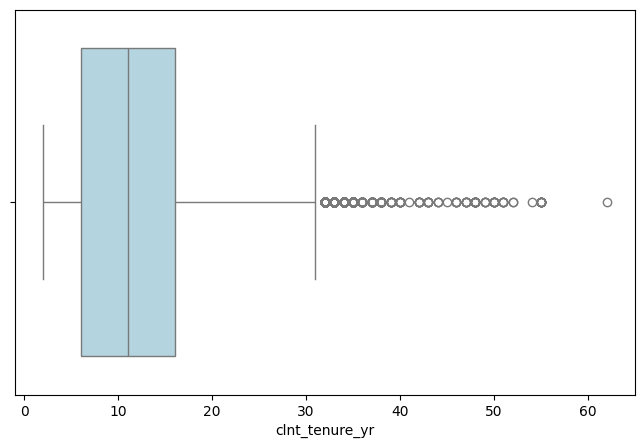

In [41]:
# Client Tenure by Year distribution
plt.figure(figsize=(8, 5))
sns.boxplot(x = df_demo['clnt_tenure_yr'], color="lightblue")
plt.show()

In [42]:
# Correlation
df_demo[['clnt_age', 'clnt_tenure_yr']].corr()

,clnt_age,clnt_tenure_yr
clnt_age,1.000000,0.309372
clnt_tenure_yr,0.309372,1.000000


In [43]:
# Calculating the Pearson correlation 'Age' and 'Tenure year'
person_correlation = df_demo['clnt_age'].corr(df_demo['clnt_tenure_yr'])
print(person_correlation)

# Calculating the Spearman rank correlation 'Age' and 'Tenure'
spearman_correlation = df_demo['clnt_age'].corr(df_demo['clnt_tenure_yr'], method='spearman')
print(spearman_correlation)

0.30937245195041824
0.30097573143540785


In [44]:
# Calculating the Pearson correlation 'Age' and 'Tenure month'
person_correlation = df_demo['clnt_age'].corr(df_demo['clnt_tenure_mnth'])
print(person_correlation)

# Calculating the Spearman rank correlation 'Age' and 'Tenure'
spearman_correlation = df_demo['clnt_age'].corr(df_demo['clnt_tenure_mnth'], method='spearman')
print(spearman_correlation)

0.30967467877269633
0.3015219863540402


The Person correlation is about 0.31, indicating a weak to moderate positive linear relationship between age and tenure. 
This means that, on average, older clients tend to have a bit more tenure, but the relationship is not very strong.

The Spearman correlation value is about 0.30, which is very close to the Pearson value, suggesting that the relationship between age and tenure is similar in terms of both linear and monotonic association.

- Summary Table
- Method	    Correlation Value	Interpretation
- Pearson	    ≈ 0.31	            Weak-to-moderate positive linear relationship
- Spearman	    ≈ 0.30	            Weak-to-moderate positive monotonic relationship

Both coefficients are positive and similar in value, indicating that as age increases, tenure tends to increase as well, but the relationship is not very strong.
The relationship appears to be fairly linear and monotonic.

In [45]:
# Correlation
df_demo[['clnt_tenure_yr', 'bal']].corr()

,clnt_tenure_yr,bal
clnt_tenure_yr,1.00000,0.20362
bal,0.20362,1.00000


In [46]:
# Calculating the Pearson correlation 'Age' and 'Tenure year'
person_correlation = df_demo['bal'].corr(df_demo['clnt_tenure_yr'])
print(person_correlation)

# Calculating the Spearman rank correlation 'Age' and 'Tenure'
spearman_correlation = df_demo['bal'].corr(df_demo['clnt_tenure_yr'], method='spearman')
print(spearman_correlation)

0.20362038717514477
0.2734921191154485


In [47]:
# Cross-tab age quantiles with tenure quantiles (Are younger clients newer? Are older clients more tenured?)
df_demo['tenure_quantile'] = pd.qcut(df_demo['clnt_tenure_yr'], q=4, labels=['T1','T2','T3','T4'])
crosstab_result = pd.crosstab(df_demo['clnt_age_quantile'], df_demo['tenure_quantile'])
crosstab_result

tenure_quantile,T1,T2,T3,T4
clnt_age_quantile,,,,
A1,7976,5339,2867,1671
A2,4180,4736,5881,2877
A3,3980,4212,5011,4838
A4,3128,3764,4403,5731


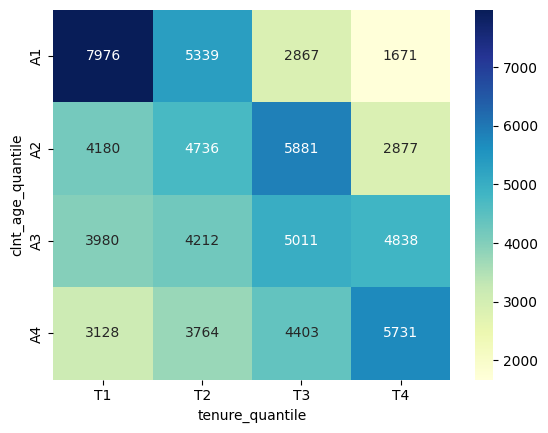

In [48]:
sns.heatmap(crosstab_result, annot=True, cmap="YlGnBu", fmt="d");

In [49]:
# Create data frame with only client inlcude in the test (Variation Not Null).
df_demo_variation = df_demo.dropna(subset='Variation')

In [50]:
df_demo_test = pd.DataFrame(df_demo_variation[df_demo_variation['Variation'] == 'Test'])
df_demo_control = pd.DataFrame(df_demo_variation[df_demo_variation['Variation'] == 'Control'])

In [51]:
for df in (df_demo_variation,df_demo_test,df_demo_control):
    display(pd.DataFrame({
        "non_nulls": df.count(),
        "nulls": df.isnull().sum(),
        "total": len(df)
    }))

,non_nulls,nulls,total
client_id,50500,0,50500
clnt_tenure_yr,50488,12,50500
clnt_tenure_mnth,50488,12,50500
clnt_age,50487,13,50500
num_accts,50488,12,50500
bal,50488,12,50500
calls_6_mnth,50488,12,50500
logons_6_mnth,50488,12,50500
Variation,50500,0,50500
clnt_age_quantile,50487,13,50500


,non_nulls,nulls,total
client_id,26968,0,26968
clnt_tenure_yr,26961,7,26968
clnt_tenure_mnth,26961,7,26968
clnt_age,26961,7,26968
num_accts,26961,7,26968
bal,26961,7,26968
calls_6_mnth,26961,7,26968
logons_6_mnth,26961,7,26968
Variation,26968,0,26968
clnt_age_quantile,26961,7,26968


,non_nulls,nulls,total
client_id,23532,0,23532
clnt_tenure_yr,23527,5,23532
clnt_tenure_mnth,23527,5,23532
clnt_age,23526,6,23532
num_accts,23527,5,23532
bal,23527,5,23532
calls_6_mnth,23527,5,23532
logons_6_mnth,23527,5,23532
Variation,23532,0,23532
clnt_age_quantile,23526,6,23532


In [52]:
for name, df in [('Variation', df_demo_variation), ('Test', df_demo_test), ('Control', df_demo_control)]:
    df.dropna(how='any',inplace=True)
    print(f"\n{name} group:")
    display(pd.DataFrame({
        "non_nulls": df.count(),
        "nulls": df.isnull().sum(),
        "total": len(df)
    }))


Variation group:


C:\Users\pablo\AppData\Local\Temp\ipykernel_3568\1210675348.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(how='any',inplace=True)


,non_nulls,nulls,total
client_id,50487,0,50487
clnt_tenure_yr,50487,0,50487
clnt_tenure_mnth,50487,0,50487
clnt_age,50487,0,50487
num_accts,50487,0,50487
bal,50487,0,50487
calls_6_mnth,50487,0,50487
logons_6_mnth,50487,0,50487
Variation,50487,0,50487
clnt_age_quantile,50487,0,50487



Test group:


,non_nulls,nulls,total
client_id,26961,0,26961
clnt_tenure_yr,26961,0,26961
clnt_tenure_mnth,26961,0,26961
clnt_age,26961,0,26961
num_accts,26961,0,26961
bal,26961,0,26961
calls_6_mnth,26961,0,26961
logons_6_mnth,26961,0,26961
Variation,26961,0,26961
clnt_age_quantile,26961,0,26961



Control group:


,non_nulls,nulls,total
client_id,23526,0,23526
clnt_tenure_yr,23526,0,23526
clnt_tenure_mnth,23526,0,23526
clnt_age,23526,0,23526
num_accts,23526,0,23526
bal,23526,0,23526
calls_6_mnth,23526,0,23526
logons_6_mnth,23526,0,23526
Variation,23526,0,23526
clnt_age_quantile,23526,0,23526


In [53]:
df_demo.to_csv(config['output_data']['file1'], index=False, sep=",", encoding="utf-8")
df_demo_variation.to_csv(config['output_data']['file2'], index=False, sep=",", encoding="utf-8")
df_demo_test.to_csv(config['output_data']['file3'], index=False, sep=",", encoding="utf-8")
df_demo_control.to_csv(config['output_data']['file4'], index=False, sep=",", encoding="utf-8")
df_web_data.to_csv(config['output_data']['file5'], index=False, sep=",", encoding="utf-8")